<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Pytorch_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lower back pain symptoms

https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

# Get Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

Lower back pain can be caused by a variety of problems with any parts of the complex, interconnected network of spinal muscles, nerves, bones, discs or tendons in the lumbar spine. Typical sources of low back pain include:

- The large nerve roots in the low back that go to the legs may be irritated
- The smaller nerves that supply the low back may be irritated
- The large paired lower back muscles (erector spinae) may be strained
- The bones, ligaments or joints may be damaged
- An intervertebral disc may be degenerating

An irritation or problem with any of these structures can cause lower back pain and/or pain that radiates or is referred to other parts of the body. Many lower back problems also cause back muscle spasms, which don't sound like much but can cause severe pain and disability.

While lower back pain is extremely common, the symptoms and severity of lower back pain vary greatly. A simple lower back muscle strain might be excruciating enough to necessitate an emergency room visit, while a degenerating disc might cause only mild, intermittent discomfort.

This data set is about to identify a person is abnormal or normal using collected physical spine details/data.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Data/Dataset_spine.csv")
df=df.iloc[:,:-1]
print(df.shape)
df.head()

(310, 13)


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


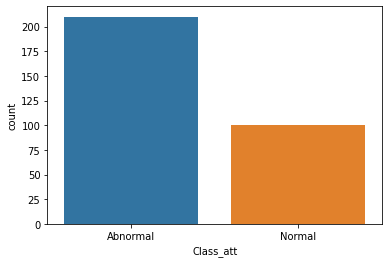

In [ ]:
sns.countplot(x = 'Class_att', data=df)

In [ ]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


## Define Custom Dataloaders

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Define Neural network

Once we’ve defined all these layers, it’s time to use them. In the forward() function, we take variable inputs as our input. We pass this input through the different layers we initialized.

The first line of the forward() functions takes the input, passes it through our first linear layer and then applies the ReLU activation on it. Then we apply BatchNorm on the output. Look at the following code to understand it better.

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(X.shape[1], 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Once, we’ve defined our architecture, we check if our GPU is active. The amazing thing about PyTorch is that it’s super easy to use the GPU.
The variable device will either say cuda:0 if we have the GPU. If not, it’ll say cpu . You can follow along this tutorial even if you do not have a GPU without any change in code.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Note that we did not use the Sigmoid activation in our final layer during training. That’s because, we use the nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation. We however, need to use Sigmoid manually during inference.

Next, we need to initialize our model. After initializing it, we move it to device . Now, this device is a GPU if you have one or it’s CPU if you don’t. The network we’ve used is fairly small. So, it will not take a lot of time to train on a CPU.

In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train model

Before we start the actual training, let’s define a function to calculate accuracy.

In the function below, we take the predicted and actual output as the input. The predicted value(a probability) is rounded off to convert it into either a 0 or a 1.

Once that is done, we simply compare the number of 1/0 we predicted to the number of 1/0 actually present and calculate the accuracy.

Note that the inputs y_pred and y_test are for a batch. Our batch_size was 64. So, this accuracy is being calculated for 64 predictions(tensors) at a time.

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

You can see we’ve put a model.train() at the before the loop. model.train() tells PyTorch that you’re in training mode.

Well, why do we need to do that? If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don’t explicitly have to write that. But it’s good practice.

Similarly, we’ll call model.eval() when we test our model. We’ll see that below.

Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we’ll print out the loss/accuracy and reset it back to 0.

Then we have another for-loop. This for-loop is used to get our data in batches from the train_loader.

We do optimizer.zero_grad() before we make any predictions. Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.

From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using loss.backward() and optimizer.step() . Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch.

This loss and accuracy is printed out in the outer for loop.

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #Get the input, data is a list of [inputs, labels], transfer to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #1. Initialise gradients 
        optimizer.zero_grad()
        #2 Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        #3 Backward
        loss.backward()
        #4 Copute the loss and update the weights
        optimizer.step()
        
        epoch_loss += loss.item() # Loss each batch
        epoch_acc += acc.item() # acc each batch
        
    # Loss and acc per each Eposhs
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.73404 | Acc: 49.500
Epoch 002: | Loss: 0.62179 | Acc: 65.500
Epoch 003: | Loss: 0.56483 | Acc: 74.750
Epoch 004: | Loss: 0.51332 | Acc: 80.000
Epoch 005: | Loss: 0.50564 | Acc: 79.250
Epoch 006: | Loss: 0.48180 | Acc: 83.250
Epoch 007: | Loss: 0.45540 | Acc: 82.750
Epoch 008: | Loss: 0.44128 | Acc: 81.000
Epoch 009: | Loss: 0.42676 | Acc: 85.500
Epoch 010: | Loss: 0.40659 | Acc: 86.500
Epoch 011: | Loss: 0.40709 | Acc: 83.250
Epoch 012: | Loss: 0.40034 | Acc: 86.000
Epoch 013: | Loss: 0.36650 | Acc: 86.250
Epoch 014: | Loss: 0.35865 | Acc: 88.000
Epoch 015: | Loss: 0.35159 | Acc: 88.250
Epoch 016: | Loss: 0.34127 | Acc: 88.000
Epoch 017: | Loss: 0.32761 | Acc: 88.500
Epoch 018: | Loss: 0.31594 | Acc: 91.250
Epoch 019: | Loss: 0.30948 | Acc: 90.000
Epoch 020: | Loss: 0.30402 | Acc: 90.250
Epoch 021: | Loss: 0.28991 | Acc: 89.250
Epoch 022: | Loss: 0.27839 | Acc: 92.000
Epoch 023: | Loss: 0.25964 | Acc: 91.750
Epoch 024: | Loss: 0.24015 | Acc: 92.500
Epoch 025: | Los

After training is done, we need to test how our model fared. Note that we’ve used model.eval() before we run our testing code. To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad() which reduces memory usage and speeds up computation.

We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch —

- We make the predictions using our trained model.
- Round off the probabilities to 1 or 0.
- Move the batch to the GPU from the CPU.
- Convert the tensor to a numpy object and append it to our list.
- Flatten out the list so that we can use it as an input to confusion_matrix and classification_report .

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch) # make predictions
        y_test_pred = torch.sigmoid(y_test_pred) # convert to propability 0-1
        y_pred_tag = torch.round(y_test_pred) # round to 0,1
        y_pred_list.append(y_pred_tag.cpu().numpy())# move batch to GPU, convert to numpy object and append to list

y_pred_list = [a.squeeze().tolist() for a in y_pred_list] #Flatten out the list for confusion matrix and classification report

In [ ]:
print(confusion_matrix(y_test, y_pred_list))
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test, y_pred_list))
print('matthews_corrcoef: ',matthews_corrcoef(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[12  6]
 [ 7 37]]
balanced_accuracy_score:  0.7537878787878788
matthews_corrcoef:  0.49974957565417644
              precision    recall  f1-score   support

           0       0.63      0.67      0.65        18
           1       0.86      0.84      0.85        44

    accuracy                           0.79        62
   macro avg       0.75      0.75      0.75        62
weighted avg       0.79      0.79      0.79        62



In [ ]:
from xgboost import XGBClassifier
model=XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Balanced accuracy score:',balanced_accuracy_score(y_test,y_pred))
print('Matthews_corrcoef accuracy score:',matthews_corrcoef(y_test,y_pred))
print(classification_report(y_test,y_pred))

Balanced accuracy score: 0.7424242424242424
Matthews_corrcoef accuracy score: 0.47079190906919977
              precision    recall  f1-score   support

           0       0.60      0.67      0.63        18
           1       0.86      0.82      0.84        44

    accuracy                           0.77        62
   macro avg       0.73      0.74      0.73        62
weighted avg       0.78      0.77      0.78        62



# Churn prediction

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,balanced_accuracy_score,matthews_corrcoef

#Special
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Prepare data

In [2]:
path='https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df=pd.read_csv(path)
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [4]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df = df.dropna()

In [5]:
#One hot encoding
dummy_cols = []
# column with value
sample_set = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].copy(deep=True)
# for other column with category, only one hot with column have nuique < 5
for col in list(df.columns):
    if col not in ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] and df[col].nunique() < 5:
        dummy_vars = pd.get_dummies(df[col])
        dummy_vars.columns = [col+str(x) for x in dummy_vars.columns]        
        sample_set = pd.concat([sample_set, dummy_vars], axis=1)
sample_set.head(10)

,tenure,MonthlyCharges,TotalCharges,Churn,genderFemale,genderMale,SeniorCitizen0,SeniorCitizen1,PartnerNo,PartnerYes,DependentsNo,DependentsYes,PhoneServiceNo,PhoneServiceYes,MultipleLinesNo,MultipleLinesNo phone service,MultipleLinesYes,InternetServiceDSL,InternetServiceFiber optic,InternetServiceNo,OnlineSecurityNo,OnlineSecurityNo internet service,OnlineSecurityYes,OnlineBackupNo,OnlineBackupNo internet service,OnlineBackupYes,DeviceProtectionNo,DeviceProtectionNo internet service,DeviceProtectionYes,TechSupportNo,TechSupportNo internet service,TechSupportYes,StreamingTVNo,StreamingTVNo internet service,StreamingTVYes,StreamingMoviesNo,StreamingMoviesNo internet service,StreamingMoviesYes,ContractMonth-to-month,ContractOne year,ContractTwo year,PaperlessBillingNo,PaperlessBillingYes,PaymentMethodBank transfer (automatic),PaymentMethodCredit card (automatic),PaymentMethodElectronic check,PaymentMethodMailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
5,8,99.65,820.50,1,1,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
6,22,89.10,1949.40,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0
7,10,29.75,301.90,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
8,28,104.80,3046.05,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
9,62,56.15,3487.95,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0


In [6]:
X = sample_set.drop(columns='Churn')
y= sample_set['Churn']
print(X.shape)
print(y.shape)
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, 
                                                     random_state = 42,stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7032, 46)
(7032,)
(5625, 46) (5625,)
(1407, 46) (1407,)


In [7]:
model=XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Balanced accuracy score:',balanced_accuracy_score(y_test,y_pred))
print('Matthews_corrcoef accuracy score:',matthews_corrcoef(y_test,y_pred))
print(classification_report(y_test,y_pred))

Balanced accuracy score: 0.6944287703640816
Matthews_corrcoef accuracy score: 0.4285486325890265
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407



## Pytorch model

In [8]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [9]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
train_data = trainData(torch.FloatTensor(X_train),torch.FloatTensor(y_train))
test_data = testData(torch.FloatTensor(X_test))

In [ ]:
X.shape[1]

46

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(X.shape[1], 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=46, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #Get the input, data is a list of [inputs, labels], transfer to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #1. Initialise gradients 
        optimizer.zero_grad()
        #2 Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        #3 Backward
        loss.backward()
        #4 Copute the loss and update the weights
        optimizer.step()
        
        epoch_loss += loss.item() # Loss each batch
        epoch_acc += acc.item() # acc each batch
        
    # Loss and acc per each Eposhs
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.53652 | Acc: 75.205
Epoch 002: | Loss: 0.45769 | Acc: 79.307
Epoch 003: | Loss: 0.42025 | Acc: 80.341
Epoch 004: | Loss: 0.40758 | Acc: 81.034
Epoch 005: | Loss: 0.40132 | Acc: 81.045
Epoch 006: | Loss: 0.39310 | Acc: 81.159
Epoch 007: | Loss: 0.39445 | Acc: 81.375
Epoch 008: | Loss: 0.39100 | Acc: 81.727
Epoch 009: | Loss: 0.38122 | Acc: 82.398
Epoch 010: | Loss: 0.38077 | Acc: 82.080
Epoch 011: | Loss: 0.37267 | Acc: 82.466
Epoch 012: | Loss: 0.37510 | Acc: 82.114
Epoch 013: | Loss: 0.36919 | Acc: 82.568
Epoch 014: | Loss: 0.36843 | Acc: 82.443
Epoch 015: | Loss: 0.36131 | Acc: 83.239
Epoch 016: | Loss: 0.35704 | Acc: 83.284
Epoch 017: | Loss: 0.35807 | Acc: 83.091
Epoch 018: | Loss: 0.35137 | Acc: 83.420
Epoch 019: | Loss: 0.35336 | Acc: 83.432
Epoch 020: | Loss: 0.34553 | Acc: 83.727
Epoch 021: | Loss: 0.33794 | Acc: 84.420
Epoch 022: | Loss: 0.34286 | Acc: 84.216
Epoch 023: | Loss: 0.33959 | Acc: 84.500
Epoch 024: | Loss: 0.33001 | Acc: 84.750
Epoch 025: | Los

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch) # make predictions
        y_test_pred = torch.sigmoid(y_test_pred) # convert to propability 0-1
        y_pred_tag = torch.round(y_test_pred) # round to 0,1
        y_pred_list.append(y_pred_tag.cpu().numpy())# move batch to GPU, convert to numpy object and append to list

y_pred = [a.squeeze().tolist() for a in y_pred_list] #Flatten out the list for confusion matrix and classification report

In [ ]:
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test, y_pred))
print('matthews_corrcoef: ',matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.6943834737098218
matthews_corrcoef:  0.40448462897704845
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.59      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



## Pytorch model 2 (with train,val and test), best model

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
#pytorch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,balanced_accuracy_score,matthews_corrcoef


In [84]:
path='https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df=pd.read_csv(path)
print(df.shape)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn'].value_counts(normalize=True)
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df = df.dropna()
#One hot encoding
dummy_cols = []
# column with value
sample_set = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].copy(deep=True)
# for other column with category, only one hot with column have nuique < 5
for col in list(df.columns):
    if col not in ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] and df[col].nunique() < 5:
        dummy_vars = pd.get_dummies(df[col])
        dummy_vars.columns = [col+str(x) for x in dummy_vars.columns]        
        sample_set = pd.concat([sample_set, dummy_vars], axis=1)
X = sample_set.drop(columns='Churn')
y= sample_set['Churn']

(7043, 21)


In [85]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,stratify=y,
                                                          random_state=2020)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval,
                                                  test_size=0.1, random_state=2020)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7032, 46) (7032,)
(5062, 46) (5062,)
(563, 46) (563,)
(1407, 46) (1407,)


In [86]:
class BinaryData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [87]:
train_data = BinaryData(torch.FloatTensor(X_train),torch.FloatTensor(y_train.values))
val_data   = BinaryData(torch.FloatTensor(X_val),torch.FloatTensor(y_val.values))
test_data = BinaryData(torch.FloatTensor(X_test),torch.FloatTensor(y_test.values))
print(train_data.X_data.shape,train_data.y_data.shape)

torch.Size([5062, 46]) torch.Size([5062])


In [88]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [89]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [90]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(X.shape[1], 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [91]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

cpu
binaryClassification(
  (layer_1): Linear(in_features=46, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [93]:
loss_stats = {'train': [],'val': []}
acc_stats={'train': [], 'val': []}

In [94]:
model.train()
for e in tqdm(range(1, EPOCHS+1)):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train() # model.train() tells PyTorch that you’re in training mode.
  for X_batch, y_batch in train_loader:
      #Get the input, data is a list of [inputs, labels], transfer to GPU
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      #1. Initialise gradients 
      optimizer.zero_grad()
      #2 Forward pass
      y_pred = model(X_batch)
      train_loss = criterion(y_pred, y_batch.unsqueeze(1))
      train_acc = binary_acc(y_pred, y_batch.unsqueeze(1))
      #3 Backward
      train_loss.backward()
      #4 Copute the loss and update the weights
      optimizer.step()
      
      train_epoch_loss += train_loss.item() # Loss each batch
      train_epoch_acc += train_acc.item() # acc each batch
         
  # VALIDATION 
  #tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.   
  with torch.no_grad():

      val_epoch_loss = 0
      val_epoch_acc = 0
      model.eval() # we’ll call model.eval() when we test our model
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          y_val_pred = model(X_val_batch)    
          val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
          val_acc = binary_acc(y_pred, y_batch.unsqueeze(1))

          val_epoch_loss += val_loss.item()
          val_epoch_acc += val_acc.item() # acc each batch

  train_loss_final=train_epoch_loss/len(train_loader) # loss each epoch
  train_acc_final =train_epoch_acc/len(train_loader) # acc each eopch
  val_loss_final  =val_epoch_loss/len(val_loader)
  val_acc_final   =val_epoch_acc/len(val_loader)

  loss_stats['train'].append(train_loss_final) # list of lost each epoch
  acc_stats['train'].append(train_acc_final)
  loss_stats['val'].append(val_loss_final)    
  acc_stats['val'].append(val_acc_final)     
  # Loss and acc per each Eposhs
  print(f'Epoch {e+0:03}: | Train Loss: {train_loss_final:.5f} | Train Acc: {train_acc_final:.3f}| Val Loss: {val_loss_final:.5f} | Val Acc: {val_acc_final:.3f}')

Epoch 001: | Train Loss: 0.57266 | Train Acc: 71.537| Val Loss: 0.49875 | Val Acc: 67.000
Epoch 002: | Train Loss: 0.48131 | Train Acc: 77.737| Val Loss: 0.46871 | Val Acc: 83.000
Epoch 003: | Train Loss: 0.43482 | Train Acc: 80.013| Val Loss: 0.45751 | Val Acc: 50.000
Epoch 004: | Train Loss: 0.41402 | Train Acc: 79.900| Val Loss: 0.46189 | Val Acc: 50.000
Epoch 005: | Train Loss: 0.40451 | Train Acc: 81.050| Val Loss: 0.45868 | Val Acc: 67.000
Epoch 006: | Train Loss: 0.40402 | Train Acc: 81.225| Val Loss: 0.44966 | Val Acc: 83.000
Epoch 007: | Train Loss: 0.39292 | Train Acc: 81.850| Val Loss: 0.44894 | Val Acc: 100.000
Epoch 008: | Train Loss: 0.38970 | Train Acc: 81.400| Val Loss: 0.44939 | Val Acc: 67.000
Epoch 009: | Train Loss: 0.37790 | Train Acc: 82.375| Val Loss: 0.44908 | Val Acc: 83.000
Epoch 010: | Train Loss: 0.38334 | Train Acc: 81.388| Val Loss: 0.45576 | Val Acc: 67.000
Epoch 011: | Train Loss: 0.37886 | Train Acc: 81.963| Val Loss: 0.45671 | Val Acc: 67.000
Epoch 012

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

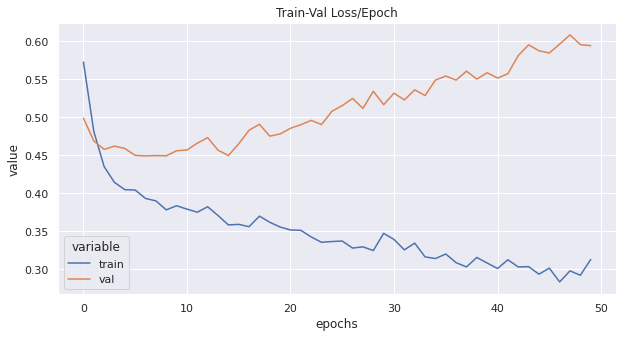

In [95]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(10,5))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val acc/Epoch')

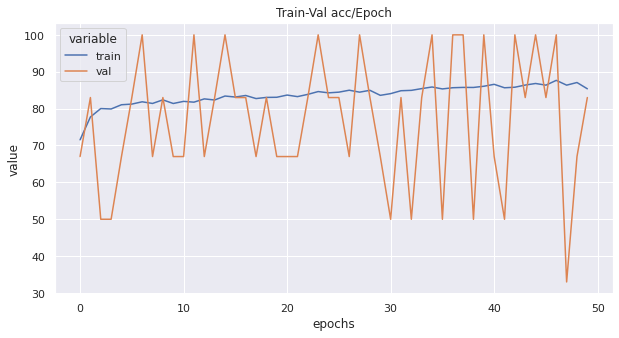

In [97]:
train_val_loss_df = pd.DataFrame.from_dict(acc_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(10,5))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val acc/Epoch')

In [98]:
y_pred_list = []
model.eval()
with torch.no_grad():
  for X_batch,_ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch) # make predictions
    y_test_pred = torch.sigmoid(y_test_pred) # convert to propability 0-1
    y_pred_tag = torch.round(y_test_pred) # round to 0,1
    y_pred_list.append(y_pred_tag.cpu().numpy())# move batch to GPU, convert to numpy object and append to list

y_pred = [a.squeeze().tolist() for a in y_pred_list] #Flatten out the list for confusion matrix and classification report
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test, y_pred))
print('matthews_corrcoef: ',matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))

balanced_accuracy_score:  0.6963661729762749
matthews_corrcoef:  0.3983395021551968
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1033
           1       0.57      0.54      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407



## Pytorch model 3 (best accuracy model)

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
#pytorch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,balanced_accuracy_score,matthews_corrcoef


In [99]:
path='https://raw.githubusercontent.com/rstudio/keras-customer-churn/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df=pd.read_csv(path)
print(df.shape)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Churn'].value_counts(normalize=True)
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)
df = df.dropna()
#One hot encoding
dummy_cols = []
# column with value
sample_set = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].copy(deep=True)
# for other column with category, only one hot with column have nuique < 5
for col in list(df.columns):
    if col not in ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'] and df[col].nunique() < 5:
        dummy_vars = pd.get_dummies(df[col])
        dummy_vars.columns = [col+str(x) for x in dummy_vars.columns]        
        sample_set = pd.concat([sample_set, dummy_vars], axis=1)
X = sample_set.drop(columns='Churn')
y= sample_set['Churn']

(7043, 21)


In [100]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,stratify=y,
                                                          random_state=2020)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval,
                                                  test_size=0.1, random_state=2020)
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7032, 46) (7032,)
(5062, 46) (5062,)
(563, 46) (563,)
(1407, 46) (1407,)


In [101]:
#from_numpy takes a numpy element and returns torch.tensor
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.values).type(torch.LongTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor)

In [102]:
#our class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(X.shape[1],3)
        
        #This applies linear transformation to produce output data
        self.fc2 = nn.Linear(3,2)
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.fc1(x)
        #Activation function is Relu. Feel free to experiment with this
        x = torch.tanh(x)
        #This produces output
        x = self.fc2(x)
        return x
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [103]:
#Initialize the model        
model = MyClassifier()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [104]:
#Number of epochs
epochs = 100
#List to store losses
losses = []
for i in range(epochs):
    #Precit the output for Given input
    y_pred = model.forward(X_train)
    #Compute Cross entropy loss
    loss = criterion(y_pred,y_train)
    #Add loss to the list
    losses.append(loss.item())
    #Clear the previous gradients
    optimizer.zero_grad()
    #Compute gradients
    loss.backward()
    #Adjust weights
    optimizer.step()

In [105]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(model.predict(X_train),y_train))
print(balanced_accuracy_score(model.predict(X_test),y_test))

0.7557564367573549
0.7495662643163646


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Pytorch model 4 (Early stopping) Fail

### Torchsample

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
#pytorch
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#Load sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report ,balanced_accuracy_score,matthews_corrcoef


In [12]:

!pip install git+https://github.com/ncullen93/torchsample

  Cloning https://github.com/ncullen93/torchsample to /tmp/pip-req-build-zkjdc0cb
  Running command git clone -q https://github.com/ncullen93/torchsample /tmp/pip-req-build-zkjdc0cb
  Created wheel for torchsample: filename=torchsample-0.1.3-cp36-none-any.whl size=43417 sha256=c2b5d47b86d83feee0136882472d3701cf36210c888b7f5822b502b1e716acdb
  Stored in directory: /tmp/pip-ephem-wheel-cache-z3ph_id6/wheels/88/c7/72/14cd9a173eed1e29d0b17d866e7d9ee511d31a834aedd27489
Successfully built torchsample


In [37]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,stratify=y,
                                                          random_state=2020)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval,
                                                  test_size=0.1, random_state=2020)

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7032, 46) (7032,)
(5062, 46) (5062,)
(563, 46) (563,)
(1407, 46) (1407,)


In [41]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(X.shape[1], 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        #x = self.layer_out(x)
        
        #return x
        return F.log_softmax(x)

In [42]:
from torchsample.modules import ModuleTrainer
from torchsample.callbacks import EarlyStopping

model = binaryClassification()
callbacks = [EarlyStopping(patience=5)]


trainer = ModuleTrainer(model)
trainer.compile(loss='nll_loss',
                optimizer='adadelta')
trainer.set_callbacks(callbacks)
trainer.fit(torch.FloatTensor(X_train), torch.LongTensor(y_train.values), 
            val_data=(torch.FloatTensor(X_val), torch.LongTensor(y_val.values)),
            num_epoch=20, 
            batch_size=128,
            verbose=1
            )

loss = model.evaluate(X_train, y_train)
y_pred = model.predict(X_test)

Epoch 1/20:   2%|▎         | 1/40 [00:00<00:02, 13.05 batches/s]


IndexError: ignored

### Pytorch lightning

In [46]:
!pip install pytorch-lightning

     |████████████████████████████████| 409kB 4.9MB/s 
     |████████████████████████████████| 2.8MB 7.9MB/s 
     |████████████████████████████████| 276kB 43.2MB/s 
     |████████████████████████████████| 829kB 40.0MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=e96fa4534551d21b7a96ec19c79369004182e4e0fd7cc5e6d8e257a51a34e0be
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=8d849da77401d35140b697fb79acd927e9929a0c43b8b054f1283cc94edc43cb
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Succes

In [51]:
from pytorch_lightning.callbacks import EarlyStopping
from torch import nn, optim, rand, sum as tsum, reshape, save
import torch.nn.functional as F
from pytorch_lightning import seed_everything, LightningModule, Trainer
from torch.utils.data import DataLoader, Dataset

In [43]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2,stratify=y,
                                                          random_state=2020)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval,
                                                  test_size=0.1, random_state=2020)

X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(7032, 46) (7032,)
(5062, 46) (5062,)
(563, 46) (563,)
(1407, 46) (1407,)


In [53]:
SAMPLE_DIM = 21000
class CustomDataset(Dataset):
    def __init__(self, samples=42):
        self.dataset = rand(samples, SAMPLE_DIM).cpu().float() * 2 - 1

    def __getitem__(self, index):
        return (self.dataset[index], (tsum(self.dataset[index]) > 0).cpu().float())

    def __len__(self):
        return self.dataset.size()[0]

In [49]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel, self).__init__()
        # Network layers
        self.linear = nn.Linear(SAMPLE_DIM, 2048)
        self.linear2 = nn.Linear(2048, 1)
        self.output = nn.Sigmoid()
        # Hyper-parameters, that we will auto-tune using lightning!
        self.lr = 0.001
        self.batch_size = 512

    def forward(self, x):
        x = self.linear(x)
        x = self.linear2(x)
        output = self.output(x)
        return reshape(output, (-1,))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        loader = DataLoader(CustomDataset(samples=43210), batch_size=self.batch_size, shuffle=True)
        return loader

    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.binary_cross_entropy(self(x), y)
        return {'loss': loss, 'log': {'train_loss': loss}}

    def val_dataloader(self):
        loader = DataLoader(CustomDataset(samples=1234), batch_size=self.batch_size, shuffle=False)
        return loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        loss = F.binary_cross_entropy(self(x), y)
        return {'val_loss': loss, 'log': {'val_loss': loss}}

    def validation_epoch_end(self, outputs):
        val_loss_mean = sum([o['val_loss'] for o in outputs]) / len(outputs)
        # show val_acc in progress bar but only log val_loss
        results = {'progress_bar': {'val_loss': val_loss_mean.item()}, 'log': {'val_loss': val_loss_mean.item()},
                   'val_loss': val_loss_mean.item()}
        return results

In [54]:

seed_everything(42)
device = 'cpu'
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, 
                                    patience=5, verbose=True, mode='auto')
model = OurModel().to(device)
trainer = Trainer(max_epochs=100, min_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  progress_bar_refresh_rate=10, early_stop_callback=early_stop_callback)
trainer.fit(model)
save(model.state_dict(), 'Location of our saved model')

EarlyStopping mode auto is unknown, fallback to auto mode.
EarlyStopping mode set to min for monitoring val_loss.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name    | Type    | Params
------------------------------------
0 | linear  | Linear  | 43 M  
1 | linear2 | Linear  | 2 K   
2 | output  | Sigmoid | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..
